# Investigate SHAP for classification interpretation based on numerical features

## Developed with miniconda Python 3.9.12
## Import Libraries

### Import Scikit learn libraries for classification, partial dependence and utility functions

conda install -c conda-forge sklearn 

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np

In [94]:
import warnings

In [95]:
warnings.filterwarnings("ignore")

### Import SHAP for python

conda install -c conda-forge shapely 

In [96]:
import shap

## Import LIME for python

conda install -c conda-forge lime

In [97]:
from lime import lime_tabular

## Download and prepare data

url: https://archive.ics.uci.edu/ml/datasets/banknote+authentication

In [98]:
notes = pd.read_csv("/Users/binayak/Projects/BITS_MTech_Dissertation/data/data_banknote_authentication.txt", header=None, 
            names=['variance','skewness','kurtosis','entropy','class'])

In [99]:
notes.head()

,variance,skewness,kurtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [100]:
notes.describe()

,variance,skewness,kurtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [101]:
# split training and validation data set
X_train, X_test, y_train, y_test = train_test_split(notes.iloc[:,0:4], notes.iloc[:,4], test_size = 0.3, random_state=0)

### Ensure spread of feature values across train and test

In [103]:

X_train.describe()

,variance,skewness,kurtosis,entropy
count,960.000000,960.000000,960.000000,960.000000
mean,0.409512,1.905185,1.385716,-1.184194
std,2.815729,5.781886,4.240443,2.095046
min,-7.042100,-13.773100,-5.286100,-7.785300
25%,-1.759150,-1.604225,-1.422000,-2.468750
50%,0.468480,2.277250,0.559225,-0.562100
75%,2.731325,6.652725,3.221850,0.400305
max,6.563300,12.951600,17.927400,2.449500


In [92]:
X_test.describe()

,variance,skewness,kurtosis,entropy
count,412.000000,412.000000,412.000000,412.000000
mean,0.490179,1.962356,1.425381,-1.209045
std,2.907459,6.074268,4.473120,2.117306
min,-6.738700,-13.677900,-5.149000,-8.548200
25%,-1.840000,-1.939975,-1.857950,-2.186525
50%,0.499450,2.489300,0.676610,-0.665530
75%,2.970525,7.039200,3.142625,0.368947
max,6.824800,12.624700,17.605200,2.162500


### Ensure equitable spread of target values across train and test

In [107]:
print(y_train.mean(), y_test.mean())

0.4479166666666667 0.4368932038834951


## Train and Test Classifier Model

In [108]:
model = RandomForestClassifier()

In [109]:
model.fit(X_train,y_train)

RandomForestClassifier()

In [26]:
f1_score(y_test,model.predict(X_test))

0.9889502762430938

#### f1_score suggests that the model has performed satisfactorily

#### Now we will leverage SHAP to attempt explain the model predictions

### Find samples to be explained

In [189]:
one_sample_idx = np.where(np.logical_and(model.predict_proba(X_test)[:,1] > 0.5 , model.predict_proba(X_test)[:,1] < 0.65))[0][0]
zero_sample_idx = np.where(np.logical_and(model.predict_proba(X_test)[:,1] > 0.35 , model.predict_proba(X_test)[:,1] < 0.5))[0][0]
print ("Validation Set Sample Index for Class 1 : [{}]".format(one_sample_idx))
print ("Validation Set Sample Index for Class 0 : [{}]".format(zero_sample_idx))

Validation Set Sample Index for Class 1 : [124]
Validation Set Sample Index for Class 0 : [250]


In [136]:
print (model.predict_proba(X_test)[one_sample_idx,1])
print (model.predict_proba(X_test)[zero_sample_idx,1])

0.51
0.38


## Explore and experiment with SHAP

#### While the model predicts the output as 0 or 1, we will take the probability of output (1 in this case) as the output and based on that, check the marginal contribution of the input features towards the output

In [27]:
# To transform the output and suite the input requirements of shap, we will extract the probability of predicting 1
f = lambda x: model.predict_proba(x)[:,1]

In [144]:
# Quick test
print ("Predicted probability for [{}]-th item to be in class [1] is [{}]".format(one_sample_idx,f([X_test.iloc[one_sample_idx]])))
print ("Actual output class value of [{}]-th item is [{}]".format(one_sample_idx,y_test.iloc[one_sample_idx]))
print("\n")
print ("Predicted probability for [{}]-th item to be in class [0] is [{}]".format(zero_sample_idx,f([X_test.iloc[zero_sample_idx]])))
print ("Actual output class value of [{}]-th item is [{}]".format(zero_sample_idx,y_test.iloc[zero_sample_idx]))

Predicted probability for [124]-th item to be in class [1] is [[0.51]]
Actual output class value of [124]-th item is [1]


Predicted probability for [250]-th item to be in class [0] is [[0.38]]
Actual output class value of [250]-th item is [0]


#### Initialize feature names

In [205]:
X_test.iloc[one_sample_idx, 0:4]

variance    0.37637
skewness   -0.82358
kurtosis    0.78543
entropy     0.74524
Name: 1075, dtype: float64

In [206]:
y_test.iloc[one_sample_idx]

1

In [148]:
feature_names = ['variance','skewness','kurtosis','entropy']

### Create Partial Dependence / Individual Contribution Plot
#### Diagram below shows that expected value of output probablity (fake note), expected value of variance and their inverse relation over the range of values of variance

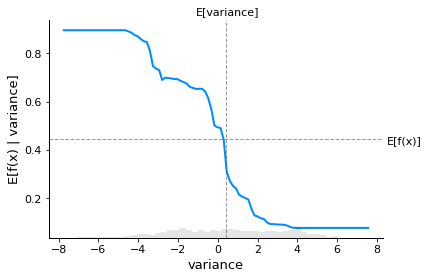

In [145]:
shap.partial_dependence_plot(
    "variance", f, notes.iloc[:,0:4], ice=False,
    model_expected_value=True, feature_expected_value=True
)

### Initialize and train the SHAP explained with shaply values of different features at different points

#### Initialize and derive expected values (default values) of feature and target based on representative sample

In [150]:
X100 = shap.utils.sample(notes.loc[:,feature_names],100)

In [151]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(f, X100)

In [152]:
shap_values = explainer(X_test)

Exact explainer: 413it [00:11,  3.76it/s]                         


### Demonstrate the partial dependence for a particular sample feature and show shaply value for the feature

In [ ]:
#for i in range(X_test.shape[0]):
#    print (i, model.predict_proba([X_test.iloc[i,:]]))

In [45]:
# Lets select a sample which we would like to be explained
sample_ind = 250
print ("Model Prediction = [{}] with probability = [{}]".format(model.predict([X_test.iloc[sample_ind,:]]),
                                                               model.predict_proba([X_test.iloc[sample_ind,:]])))

Model Prediction = [[0]] with probability = [[[0.67 0.33]]]


[]

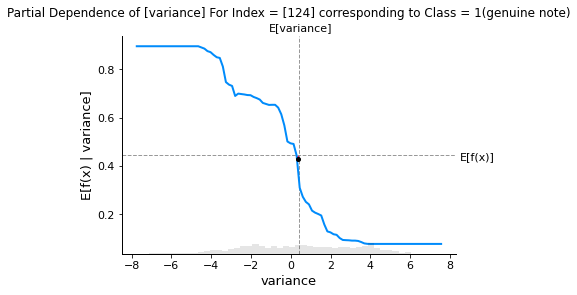

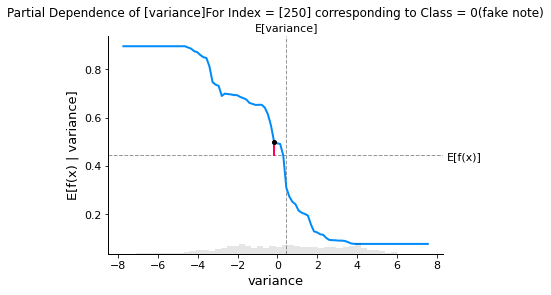

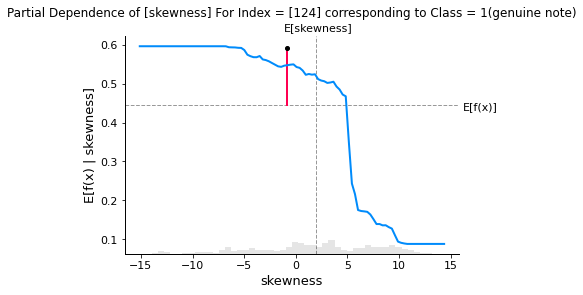

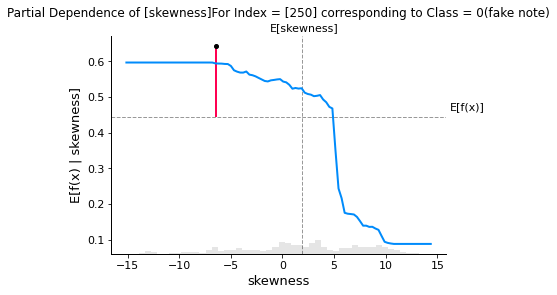

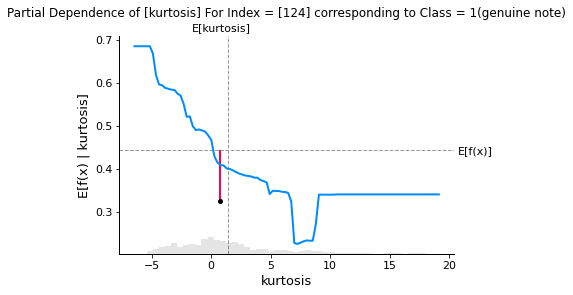

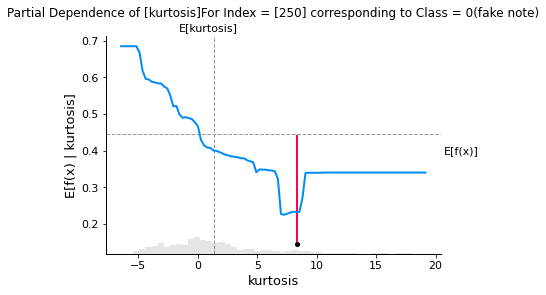

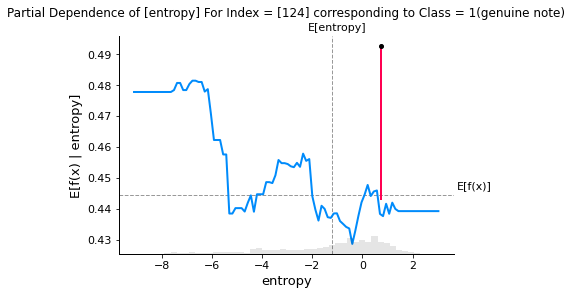

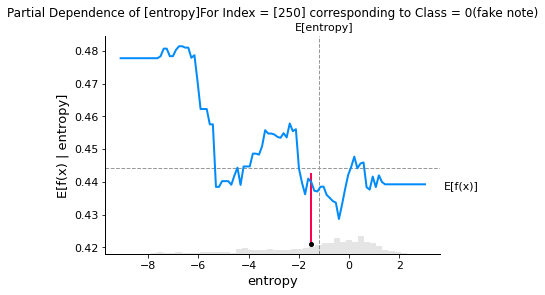

In [177]:
# make a standard partial dependence plot for feature
for feature in feature_names:
    shap.partial_dependence_plot(
        feature, f, notes.iloc[:,0:4], model_expected_value=True,
        feature_expected_value=True, ice=False,
        shap_values=shap_values[one_sample_idx:one_sample_idx+1,:], show=False
    )
    plt.title("Partial Dependence of [{}] For Index = [{}] corresponding to Class = 1(genuine note)".format(feature, one_sample_idx))
    shap.partial_dependence_plot(
        feature, f, notes.iloc[:,0:4], model_expected_value=True,
        feature_expected_value=True, ice=False,
        shap_values=shap_values[zero_sample_idx:zero_sample_idx+1,:], show=False
    )
    plt.title("Partial Dependence of [{}]For Index = [{}] corresponding to Class = 0(fake note)".format(feature, zero_sample_idx))
plt.plot()


### Display / Explain effect of individual feature towards prediction outcome at a particular point in feature space
#### The diagram clearly shows how the additive result of shaply values of indivudual feature pushed the output from its expected value to the predicted value


[]

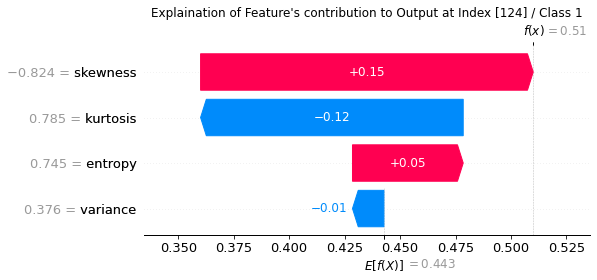

In [187]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]

shap.plots.waterfall(shap_values[one_sample_idx], max_display=14, show = False)
plt.title("Explaination of Feature's contribution to Output at Index [{}] / Class 1".format(one_sample_idx))
plt.plot()

[]

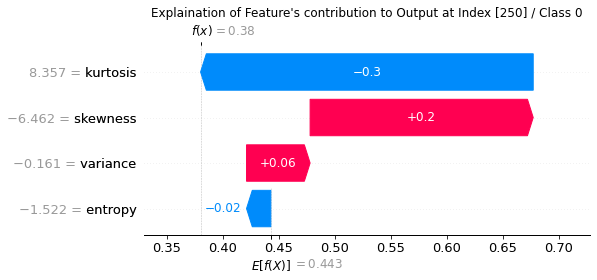

In [188]:
shap.plots.waterfall(shap_values[zero_sample_idx], max_display=14, show = False)
plt.title("Explaination of Feature's contribution to Output at Index [{}] / Class 0".format(zero_sample_idx))
plt.plot()

### Verifying the explaination graph above against the data

In [327]:
# Feature values
notes.iloc[sample_ind,0:4]

variance    4.17110
skewness    8.72200
kurtosis   -3.02240
entropy    -0.59699
Name: 40, dtype: float64

In [328]:
# Predicted probability of 1 at chosen sample
f([notes.iloc[sample_ind,0:4]])

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([0.])

In [329]:
# Actual value of target at chosen sample
notes.iloc[sample_ind,4]

0

In [207]:
explainer_lime = lime_tabular.LimeTabularExplainer(
    np.array(X_train),
    feature_names=X_train.columns,
    verbose=True, class_names = ["Fake","Genuine"],
    mode='classification',
    random_state = 0,
    feature_selection = "lasso_path", kernel_width = 2)

Intercept 0.34346651192935457
Prediction_local [0.67161878]
Right: 0.51




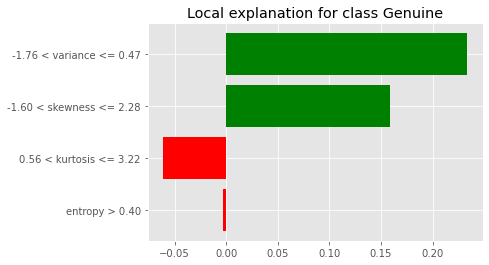

In [213]:
exp = explainer_lime.explain_instance(
    data_row=X_test.iloc[one_sample_idx], 
    predict_fn=model.predict_proba
)
print("\n")
exp.show_in_notebook(show_table=True)
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()

Intercept 0.3546640959619704
Prediction_local [0.61310046]
Right: 0.38




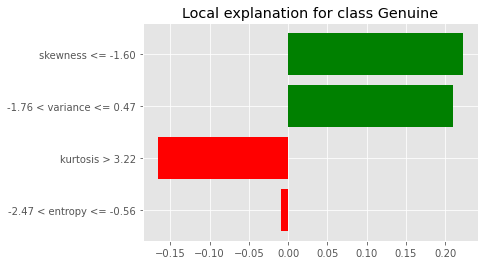

In [214]:
exp = explainer_lime.explain_instance(
    data_row=X_test.iloc[zero_sample_idx], 
    predict_fn=model.predict_proba
)
print("\n")
exp.show_in_notebook(show_table=True)
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()